In [2]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)
print('TensorFlow version:',tf.__version__)
print('Keras version:',tf.keras.__version__)

2.4.1
TensorFlow version: 2.4.1
Keras version: 2.4.0


In [3]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
classes = pd.read_csv("data/Train.csv")

In [5]:
classes.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [6]:
min_width, max_width = max(classes.Width), min(classes.Width)
min_height, max_height = max(classes.Height), min(classes.Height)

print(np.mean([min_width, max_width]))
print(np.mean([min_height, max_height]))

134.0
125.0


In [7]:
classes_no = len(classes.ClassId.unique())
print("There are {} unique classes in the dataset.".format(classes_no))

There are 43 unique classes in the dataset.


In [8]:
TARGET_SIZE = (125, 125)

#### Load a pre-trained model

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(input_shape=(125, 125, 3), weights='imagenet', include_top=False)

In [10]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 125, 125, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 62, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 62, 62, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 62, 62, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [24]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Add a dropout layer to avoid overfitting (drop 20%)
# and a logistic layer
predictions = Dense(classes_no, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy', 'categorical_crossentropy'])

Load the data and use data augmentation

In [19]:
cwd = os.getcwd()
base_dir = os.path.join(cwd, 'data')
train_path= os.path.join(base_dir, 'Train')

In [20]:
BATCH_SIZE = 20

In [25]:
# Create a data generator for the training images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)  # val 20%

# Create a data generator for the validation images
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Split data to training and validation datasets
train_data = train_datagen.flow_from_directory(train_path, 
                                               target_size=TARGET_SIZE, 
                                               color_mode='rgb',
                                               batch_size=BATCH_SIZE, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset = 'training') 

val_data = val_datagen.flow_from_directory(train_path, 
                                           target_size=TARGET_SIZE, 
                                           color_mode='rgb',
                                           batch_size=BATCH_SIZE, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           subset = 'validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='categorical_crossentropy', patience=10)

In [28]:
history = model.fit(
      train_data,
      steps_per_epoch= train_data.samples // BATCH_SIZE,  # One pass through entire training dataset
      epochs=100,
      validation_data=val_data,
      validation_steps= val_data.samples // BATCH_SIZE,  # One pass through entire validation dataset
      validation_freq=10,
      verbose=1)

Epoch 1/100
1568/1568 [==============================] - 250s 159ms/step - loss: 1.5309 - accuracy: 0.6045 - categorical_crossentropy: 1.5309
Epoch 2/100
1568/1568 [==============================] - 110s 70ms/step - loss: 1.5462 - accuracy: 0.5985 - categorical_crossentropy: 1.5462
Epoch 3/100
1568/1568 [==============================] - 112s 71ms/step - loss: 1.5453 - accuracy: 0.6045 - categorical_crossentropy: 1.5453
Epoch 4/100
1568/1568 [==============================] - 112s 71ms/step - loss: 1.5736 - accuracy: 0.6020 - categorical_crossentropy: 1.5736
Epoch 5/100
1568/1568 [==============================] - 113s 72ms/step - loss: 1.5878 - accuracy: 0.6019 - categorical_crossentropy: 1.5878
Epoch 6/100
1568/1568 [==============================] - 112s 71ms/step - loss: 1.5965 - accuracy: 0.6018 - categorical_crossentropy: 1.5965
Epoch 7/100
1568/1568 [==============================] - 112s 71ms/step - loss: 1.6131 - accuracy: 0.6041 - categorical_crossentropy: 1.6131
Epoch 8/100


KeyboardInterrupt: 

In [29]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [30]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

history2 = model.fit(
      train_data,
      steps_per_epoch= train_data.samples // BATCH_SIZE,  # One pass through entire training dataset
      epochs=20,
      validation_data=val_data,
      validation_steps= val_data.samples // BATCH_SIZE,  # One pass through entire validation dataset
      validation_freq=10,
      verbose=1)

Epoch 1/20
1568/1568 [==============================] - 113s 72ms/step - loss: 1.5671 - accuracy: 0.5388
Epoch 2/20
1568/1568 [==============================] - 113s 72ms/step - loss: 1.2202 - accuracy: 0.6188
Epoch 3/20
1568/1568 [==============================] - 158s 101ms/step - loss: 1.0766 - accuracy: 0.6577
Epoch 4/20
1568/1568 [==============================] - 220s 141ms/step - loss: 0.9575 - accuracy: 0.6917
Epoch 5/20
1568/1568 [==============================] - 166s 106ms/step - loss: 0.8800 - accuracy: 0.7143
Epoch 6/20
1568/1568 [==============================] - 173s 110ms/step - loss: 0.8157 - accuracy: 0.7345
Epoch 7/20
1568/1568 [==============================] - 177s 113ms/step - loss: 0.7631 - accuracy: 0.7513
Epoch 8/20
1568/1568 [==============================] - 176s 112ms/step - loss: 0.7247 - accuracy: 0.7611
Epoch 9/20
1568/1568 [==============================] - 177s 113ms/step - loss: 0.6851 - accuracy: 0.7756
Epoch 10/20
1568/1568 [=========================

In [42]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (20,) and (2,)

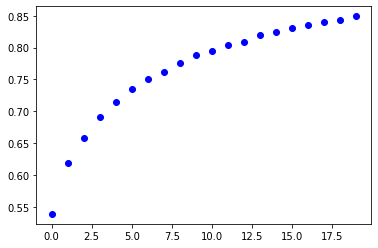

In [101]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
#plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
model.save('trained_model/my_model_2') 

INFO:tensorflow:Assets written to: trained_model/my_model_2\assets


In [ ]:
model_path = os.path.join(cwd, "saved_model/my_model2")
model = tf.keras.models.load_model(model_path)

In [180]:
path = os.path.join(cwd, "data", "Test", "00010.png")
img = tf.keras.preprocessing.image.load_img(path, target_size=(125, 125))

array([4], dtype=int64)

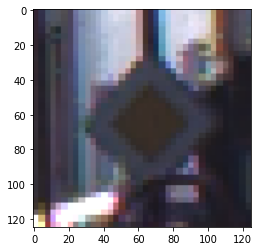

In [181]:
x = tf.keras.preprocessing.image.img_to_array(img)/255
x = np.expand_dims(x, axis=0)
classes = model.predict(x, batch_size=0)
plt.imshow(img)
np.argmax(classes, axis=1)

In [182]:
class_labels = pd.read_csv("data/class_labels.csv")

In [212]:
test_labels_df = pd.read_csv("data/Test.csv", index_col=False)
test_labels = test_labels_df["ClassId"].values
test_labels[10]

12

In [215]:
np.shape(labels)

(12630, 1)

In [211]:
import glob
test_image_path = glob.glob('Data/Test/*.*')

In [214]:
labels = np.expand_dims(test_labels, axis=1)

In [171]:
data = []

for img in test_image_path[0:1000]:   
    img = tf.keras.preprocessing.image.load_img(img, target_size=(125, 125))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = x/255
    data.append(x)

In [173]:
results = model.evaluate(np.array(data), labels[0:1000], batch_size=20)

50/50 [==============================] - 2s 44ms/step - loss: 35679.6328 - accuracy: 0.0070


In [111]:
import glob
test_image_path = glob.glob('Data/Train/3/*.*')

In [114]:
test_labels = np.repeat(3, len(test_image_path))

In [115]:
labels = np.expand_dims(test_labels, axis=1)

In [122]:
np.array(data)

array([[[[ 29.,  30.,  31.],
         [ 29.,  30.,  31.],
         [ 29.,  30.,  31.],
         ...,
         [ 30.,  33.,  30.],
         [ 30.,  33.,  30.],
         [ 30.,  33.,  30.]],

        [[ 29.,  30.,  31.],
         [ 29.,  30.,  31.],
         [ 29.,  30.,  31.],
         ...,
         [ 30.,  33.,  30.],
         [ 30.,  33.,  30.],
         [ 30.,  33.,  30.]],

        [[ 29.,  30.,  31.],
         [ 29.,  30.,  31.],
         [ 29.,  30.,  31.],
         ...,
         [ 30.,  33.,  30.],
         [ 30.,  33.,  30.],
         [ 30.,  33.,  30.]],

        ...,

        [[ 38.,  37.,  38.],
         [ 38.,  37.,  38.],
         [ 38.,  37.,  38.],
         ...,
         [ 42.,  40.,  34.],
         [ 42.,  40.,  34.],
         [ 42.,  40.,  34.]],

        [[ 38.,  37.,  38.],
         [ 38.,  37.,  38.],
         [ 38.,  37.,  38.],
         ...,
         [ 42.,  40.,  34.],
         [ 42.,  40.,  34.],
         [ 42.,  40.,  34.]],

        [[ 38.,  37.,  38.],
       

In [121]:
labels

array([[3],
       [3],
       [3],
       ...,
       [3],
       [3],
       [3]])

In [185]:
data_3 = []

for img in test_image_path:   
    img = tf.keras.preprocessing.image.load_img(img, target_size=(125, 125))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = x/255
    data_3.append(x)

In [186]:
results = model.evaluate(np.array(data_3), labels, batch_size=20)

632/632 [==============================] - 28s 45ms/step - loss: 35855.0234 - accuracy: 0.0036


In [ ]:
#Train longer

In [141]:
# Create a data generator for the training images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)  # val 20%

# Create a data generator for the validation images
val_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)

#Split data to training and validation datasets
train_data = train_datagen.flow_from_directory(train_path, 
                                               target_size=TARGET_SIZE, 
                                               color_mode='rgb',
                                               batch_size=BATCH_SIZE, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=2,
                                               subset = 'training') 

val_data = val_datagen.flow_from_directory(train_path, 
                                           target_size=TARGET_SIZE, 
                                           color_mode='rgb',
                                           batch_size=BATCH_SIZE, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=2
                                           subset = 'validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [142]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

history2 = model.fit(
      train_data,
      steps_per_epoch= train_data.samples // BATCH_SIZE,  # One pass through entire training dataset
      epochs=10,
      validation_data=val_data,
      validation_steps= val_data.samples // BATCH_SIZE,  # One pass through entire validation dataset
      validation_freq=1,
      verbose=1)

Epoch 1/10
1568/1568 [==============================] - 235s 150ms/step - loss: 0.3183 - accuracy: 0.8930 - val_loss: 0.9980 - val_accuracy: 0.7726
Epoch 2/10
1568/1568 [==============================] - 227s 145ms/step - loss: 0.2493 - accuracy: 0.9156 - val_loss: 0.9794 - val_accuracy: 0.7811
Epoch 3/10
1568/1568 [==============================] - 116s 74ms/step - loss: 0.2044 - accuracy: 0.9309 - val_loss: 1.0011 - val_accuracy: 0.7876
Epoch 4/10
1568/1568 [==============================] - 116s 74ms/step - loss: 0.1782 - accuracy: 0.9397 - val_loss: 1.0349 - val_accuracy: 0.7899
Epoch 5/10
1568/1568 [==============================] - 116s 74ms/step - loss: 0.1514 - accuracy: 0.9489 - val_loss: 1.0647 - val_accuracy: 0.7927
Epoch 6/10
1568/1568 [==============================] - 115s 74ms/step - loss: 0.1283 - accuracy: 0.9568 - val_loss: 1.1059 - val_accuracy: 0.7973
Epoch 7/10
1568/1568 [==============================] - 116s 74ms/step - loss: 0.1221 - accuracy: 0.9593 - val_loss:

In [219]:
cwd = os.getcwd()
base_dir = os.path.join(cwd, 'data')
test_path= os.path.join(base_dir, 'Test')

In [282]:
test_path

'C:\\Users\\LONAA32\\Documents\\Repos\\traffic-sign-recognition\\data\\Test'

In [283]:
datagen = ImageDataGenerator(rescale=1./255)
test_data = datagen.flow_from_directory(test_path,
                                               target_size=TARGET_SIZE, 
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True)

Found 12630 images belonging to 43 classes.


In [225]:
results = model.evaluate(test_data, batch_size=20)

395/395 [==============================] - 74s 185ms/step - loss: 11.0264 - accuracy: 0.6553


In [284]:
predictions = np.argmax(model.predict(test_data, steps=1), axis=1)

10 32


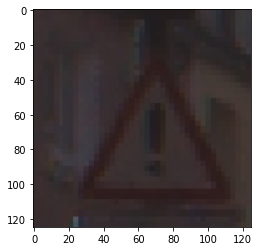

29 23


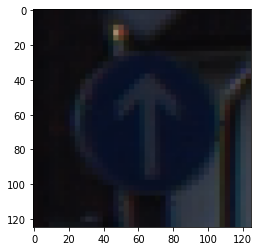

29 25


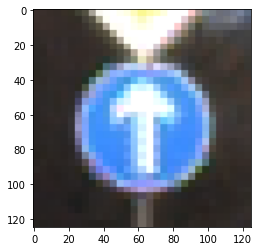

18 5


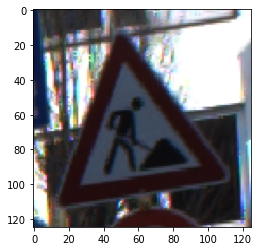

10 12


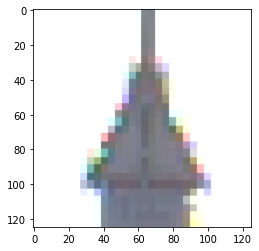

22 12


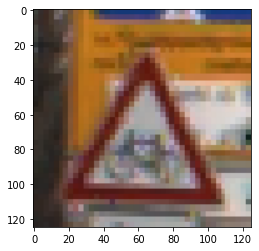

25 41


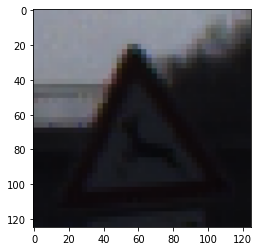

31 2


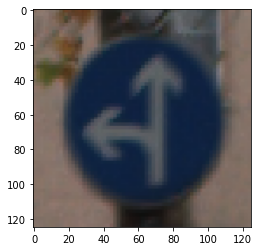

40 3


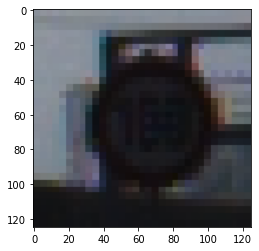

4 3


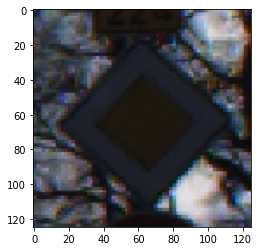

3 3


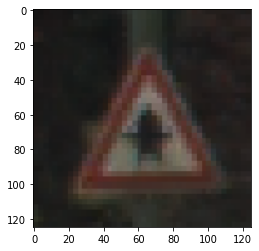

24 12


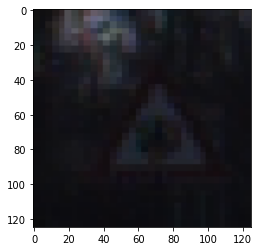

22 12


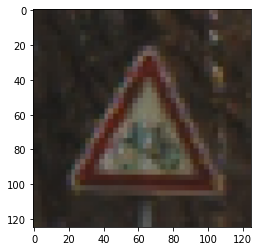

2 2


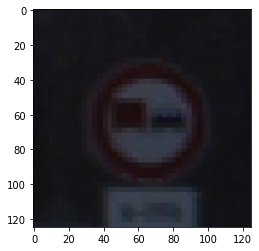

5 30


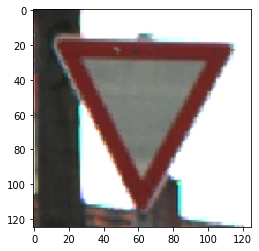

3 7


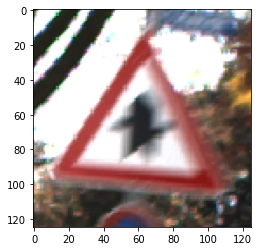

6 41


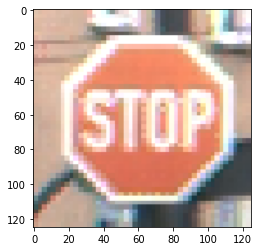

32 17


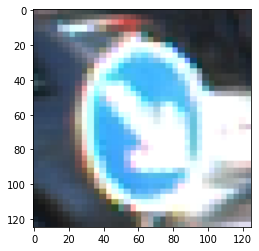

36 1


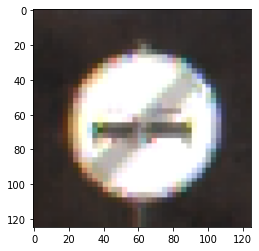

42 4


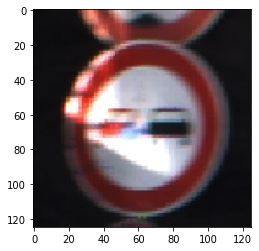

In [285]:
test_labels_com=[]

for i in range(len(predictions)):
    img, label = test_data.next()
    l = np.argmax(label[0])
    print(l, predictions[i])
    test_labels_com.append(l)
    plt.imshow(img[0])
    plt.show()

In [286]:
number_of_examples

12630

In [274]:
import math

number_of_examples = len(test_data.filenames)
#number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 1)) 

test_labels_com = []

for i in range(0, int(number_of_examples)):
    test_labels_com.append(np.argmax(test_data[i][1]))

ValueError: Asked to retrieve element 395, but the Sequence has length 395

In [ ]:
test_labels_com

In [ ]:
tf.stack([np.argmax(predictions, axis=1), test_labels_com], axis=1)